#Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations
## Authors: M. Raissi, P. Perdikaris, G.E. Karniadakis
## Team: Abby Schmid, Thomas Allard, Yang Xu

Imports and installs

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thomas-allard/APPM5720/blob/master/NavierStokeExample.ipynb)


In [2]:
!pip install sciann &> /dev/null
!pip install matplotlib &> /dev/null
!pip install scipy &> /dev/null
#!/usr/bin/env python3


## exact value of the parameters: lambda1 = 1.0, lambda2 = 0.01
import numpy as np 
import sciann as sn 
import matplotlib.pyplot as plt
import scipy.io

import os
# sns.set_theme()

---------------------- SCIANN 0.6.5.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.5.3 
Python Version: 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0] 



In [78]:
# Specify parameters and things
mode = 'test'   # 'test' to load PINN weights from previously trained model
                # 'train' to train a new model

trained_file = 'trained-navier-stokes.hdf5'
data_file = 'cylinder_nektar_wake.mat'

In [79]:
# define function for subsampling data
def PrepareData(num_data, data_file, random=True):
    
    # Load data
    #data = scipy.io.loadmat('/content/' + data_file)
    data = scipy.io.loadmat(data_file)
    
    U_star = data['U_star'] # N x 2 x T
    P_star = data['p_star'] # N x T
    t_star = data['t'] # T x 1
    X_star = data['X_star'] # N x 2
    
    N = X_star.shape[0]
    T = t_star.shape[0]
    
    # Rearrange Data 
    XX = np.tile(X_star[:,0:1], (1,T)) # N x T
    YY = np.tile(X_star[:,1:2], (1,T)) # N x T
    TT = np.tile(t_star, (1,N)).T # N x T
    
    UU = U_star[:,0,:] # N x T
    VV = U_star[:,1,:] # N x T
    PP = P_star # N x T
    
    # Pick random data.
    if random:
        idx = np.random.choice(N*T, num_data, replace=False)
    else:
        idx = np.arange(0, N*T)
    
    x = XX.flatten()[idx,None] # NT x 1
    y = YY.flatten()[idx,None] # NT x 1
    t = TT.flatten()[idx,None] # NT x 1
    
    u = UU.flatten()[idx,None] # NT x 1
    v = VV.flatten()[idx,None] # NT x 1
    p = PP.flatten()[idx,None] # NT x 1
 
    return (x,y,t,u,v,p)


In [81]:
# Setting up cost function
layers = 8
neurons = 20

x = sn.Variable("x", dtype='float64')
y = sn.Variable("y", dtype='float64')
t = sn.Variable("t", dtype='float64')

P = sn.Functional("P", [x, y, t], layers*[neurons], 'tanh')
Psi = sn.Functional("Psi", [x, y, t], layers*[neurons], 'tanh')

lambda1 = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda1")
lambda2 = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda2")
## true value lamdba1 = 

u = sn.diff(Psi, y)
v = -sn.diff(Psi, x)

u_t = sn.diff(u, t)
u_x = sn.diff(u, x)
u_y = sn.diff(u, y)
u_xx = sn.diff(u, x, order=2)
u_yy = sn.diff(u, y, order=2)

v_t = sn.diff(v, t)
v_x = sn.diff(v, x)
v_y = sn.diff(v, y)
v_xx = sn.diff(v, x, order=2)
v_yy = sn.diff(v, y, order=2)

p_x = sn.diff(P, x)
p_y = sn.diff(P, y)

# Define constraints 
d1 = sn.Data(u)
d2 = sn.Data(v)
d3 = sn.Data(P)

c1 = sn.Tie(-p_x, u_t+lambda1*(u*u_x+v*u_y)-lambda2*(u_xx+u_yy))
c2 = sn.Tie(-p_y, v_t+lambda1*(u*v_x+v*v_y)-lambda2*(v_xx+v_yy))
c3 = sn.Data(u_x + v_y)

c4 = Psi*0.0

if mode == 'train':
    x_train, y_train, t_train, u_train, v_train, p_train = PrepareData(5000, data_file, random=True)
# Define the optimization model (set of inputs and constraints)
    model = sn.SciModel(
        inputs=[x, y, t],
        targets=[d1, d2, d3, c1, c2, c3, c4],
        loss_func="mse",
        plot_to_file='NS-Model.png'
    )

    input_data = [x_train, y_train, t_train]

    data_d1 = u_train
    data_d2 = v_train
    data_d3 = p_train
    data_c1 = 'zeros'
    data_c2 = 'zeros'
    data_c3 = 'zeros'
    data_c4 = 'zeros'
    target_data = [data_d1, data_d2, data_d3, data_c1, data_c2, data_c3, data_c4]

    ## hyper parameter define

    Epochs= 10000
    Batch_size=100
    Learning_rate=0.001
    Reduce_lr_after=1000

    #log the data

    log_directory = f'../logs/log_layers{layers}_neurons{neurons}_epochs{Epochs}_batchsize{Batch_size}_learning_rate{Learning_rate}_reduce_lr_after{Reduce_lr_after}'

    if not os.path.exists(log_directory):
        os.makedirs(log_directory)
        print(f'{log_directory} is created!')

    ##train PINN

    history = model.train(
        x_true=input_data,
        y_true=target_data,
        epochs= Epochs,
        batch_size= Batch_size,
        shuffle=True,
        learning_rate= Learning_rate,
        reduce_lr_after= Reduce_lr_after,
        stop_loss_value=1e-8,
        verbose=1,
        log_parameters={'parameters':[lambda1,lambda2],
                        'freq':1}
    )

    ## logs and plots
    model.save_weights('trained-navier-stokes.hdf5')
    ## print iterated parameters value
    print("lambda1: {},  lambda2: {}".format(lambda1.value, lambda2.value))
    with open(f'../logs/log_layers{layers}_neurons{neurons}_epochs{Epochs}_batchsize{Batch_size}_learning_rate{Learning_rate}_reduce_lr_after{Reduce_lr_after}/parameters_{layers}_{neurons}.txt', 'w') as f:
        f.write(f"lambda1: {lambda1.value},  lambda2: {lambda2.value}")
    print("lambda1: {},  lambda2: {}".format(lambda1.value, lambda2.value))

    ## print loss function value
    print("loss: {}".format(history.history['loss']))
    with open(f'../logs/log_layers{layers}_neurons{neurons}_epochs{Epochs}_batchsize{Batch_size}_learning_rate{Learning_rate}_reduce_lr_after{Reduce_lr_after}/loss_{layers}_{neurons}.txt', 'w') as f:
        f.write(f"loss: {history.history['loss']}")
    ## plot loss function
    plt.figure(f'Train_Loss_{layers}_{neurons}')
    plt.semilogy(history.history['loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.savefig(f'../logs/log_layers{layers}_neurons{neurons}_epochs{Epochs}_batchsize{Batch_size}_learning_rate{Learning_rate}_reduce_lr_after{Reduce_lr_after}/loss_{layers}_{neurons}.png')
    plt.semilogy(history.history['loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')

In [82]:
if mode == 'test':
    x_test, y_test, t_test, u_test, test, p_test = PrepareData(5000, data_file, random=True)
    test_input_data = [x_test, y_test, t_test]

    model = sn.SciModel(
        inputs=[x, y, t],
        targets=[d1, d2, d3, c1, c2, c3, c4],
        loss_func="mse",
        load_weights_from= trained_file
    )
    ## load prediction output
    test_result = model.predict(test_input_data, batch_size=None, verbose=0, steps=None)
    p_pred = test_result[6]
    #n_size = int(np.sqrt(x_test.shape[0]))

    #ux_mae = mae(ux_test, test_result[0])
    #uy_mae = mae(uy_test, test_result[1])
    #print(f'UX mae is: {ux_mae}, UY mae is {uy_mae}')
    print("lambda1: {},  lambda2: {}".format(lambda1.value, lambda2.value))
    #print("lambda1: {},  lambda2: {}".format(lambda_parameter.value, mu_parameter.value, rho_parameter.value))

    #import pdb; pdb.set_trace()

    #from scipy.io import savemat

    #mdic = {"ux_pred": test_result[0].reshape(n_size,n_size),"uy_pred": test_result[1].reshape(n_size,n_size),"label": "pinn_result_source_0"}

    #savemat("pinn_result_source_0.mat", mdic)



    #plt.figure()
    #sns.heatmap(test_result[0].reshape(n_size,n_size))
    #plt.figure()
    #sns.heatmap(test_result[1].reshape(n_size,n_size))
    #plt.show()
    # st()


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


lambda1: [0.99794099],  lambda2: [0.0108588]


In [83]:
#PLOT PRESSURES!

# Load data
data = scipy.io.loadmat(data_file)

# Unpacking the .mat file 
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2
snap = np.array([100])
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
p_star = P_star[:,snap]
#p_test = P_pred[:,snap]
# Predict for plotting
lb = X_star.min(0)
ub = X_star.max(0)
nn = 200
x = np.linspace(lb[0], ub[0], nn)
y = np.linspace(lb[1], ub[1], nn)
X, Y = np.meshgrid(x,y)

from scipy.interpolate import griddata
P_exact = griddata(X_star, p_star.flatten(), (X, Y), method='cubic')

PP_star = griddata(X_star, p_pred.flatten(), (X, Y), method='cubic')


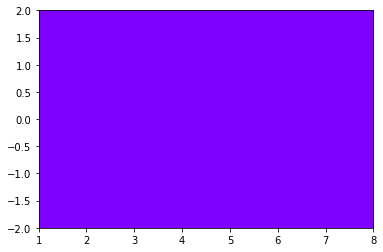

In [84]:
plt.imshow(PP_star, interpolation='nearest', cmap='rainbow', 
                  extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
                  origin='lower', aspect='auto')

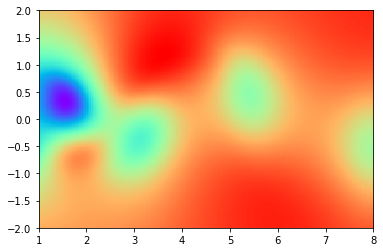

In [32]:
plt.imshow(P_exact, interpolation='nearest', cmap='rainbow', 
                  extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
                  origin='lower', aspect='auto')

What should classmates do with trained PINNs?
- Plot pressure distribution at some time
- Print lambdas